[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yhtang/FunFact/blob/master/docs/examples/matrix-approximation.ipynb)

# Matrix Approximation

## Install package and obtain assets if running on Google Colab

In [1]:
try:
    import google.colab
    !pip install funfact scikit-image
    !pip install -U scikit-image
    !wget https://upload.wikimedia.org/wikipedia/en/8/86/Einstein_tongue.jpg
except:
    pass

## Imports and visualization setup

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
import funfact as ff

In [3]:
ff.use('jax')

## SVD as a baseline


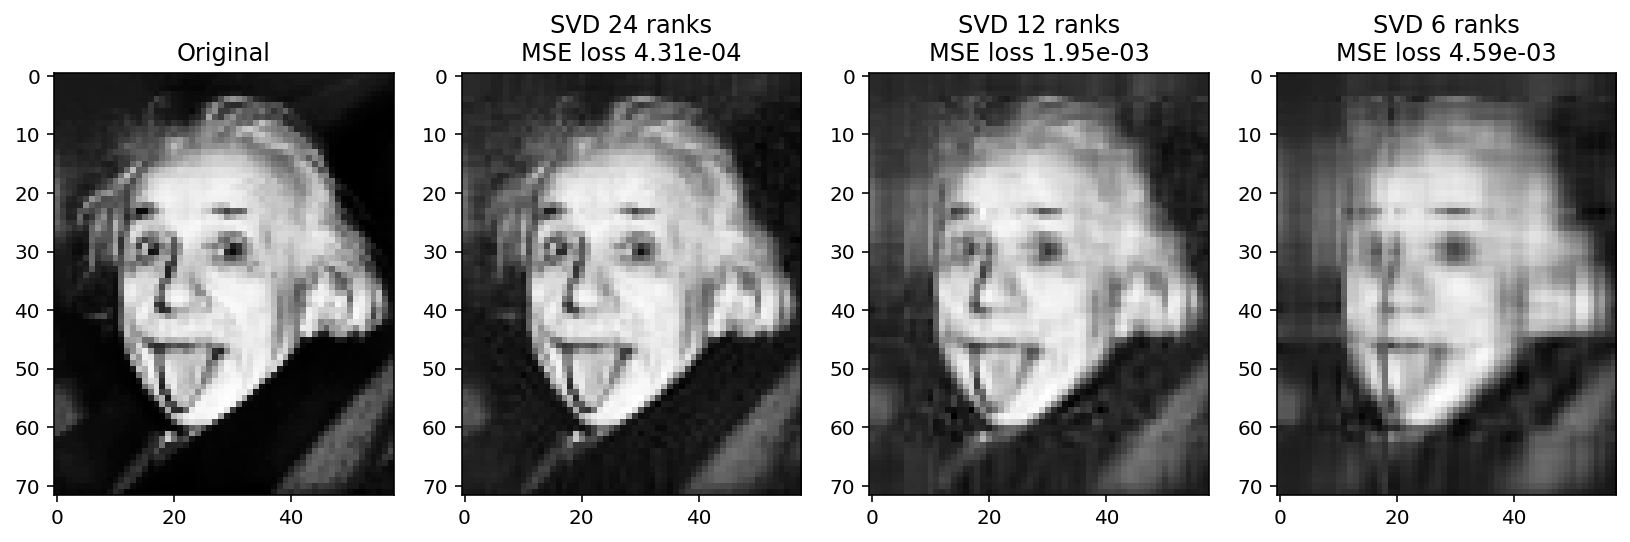

In [4]:
img = ski.transform.rescale(ski.io.imread('Einstein_tongue.jpg'), 0.25, anti_aliasing=True)
img **= 1.8  # gamma correction

ranks = [24, 12, 6]
U, S, V = np.linalg.svd(img)
img_svd = []
for r in ranks:
    img_svd.append((U[:, :r] * S[:r]) @ V[:r, :])


fig, axs = plt.subplots(1, 4, figsize=(14, 4))
axs[0].imshow(img, cmap='Greys_r')
axs[0].set_title('Original')

for r, img_compressed, ax in zip(ranks, img_svd, axs[1:]):
    ax.imshow(img_compressed, cmap='Greys_r')
    ax.set_title('SVD {} ranks\nMSE loss {:.2e}'.format(r, ff.loss.mse_loss(img_compressed, img)))

plt.show()

## Solving SVD with gradient descent

100%|██████████| 1000/1000 [00:02<00:00, 394.40it/s]


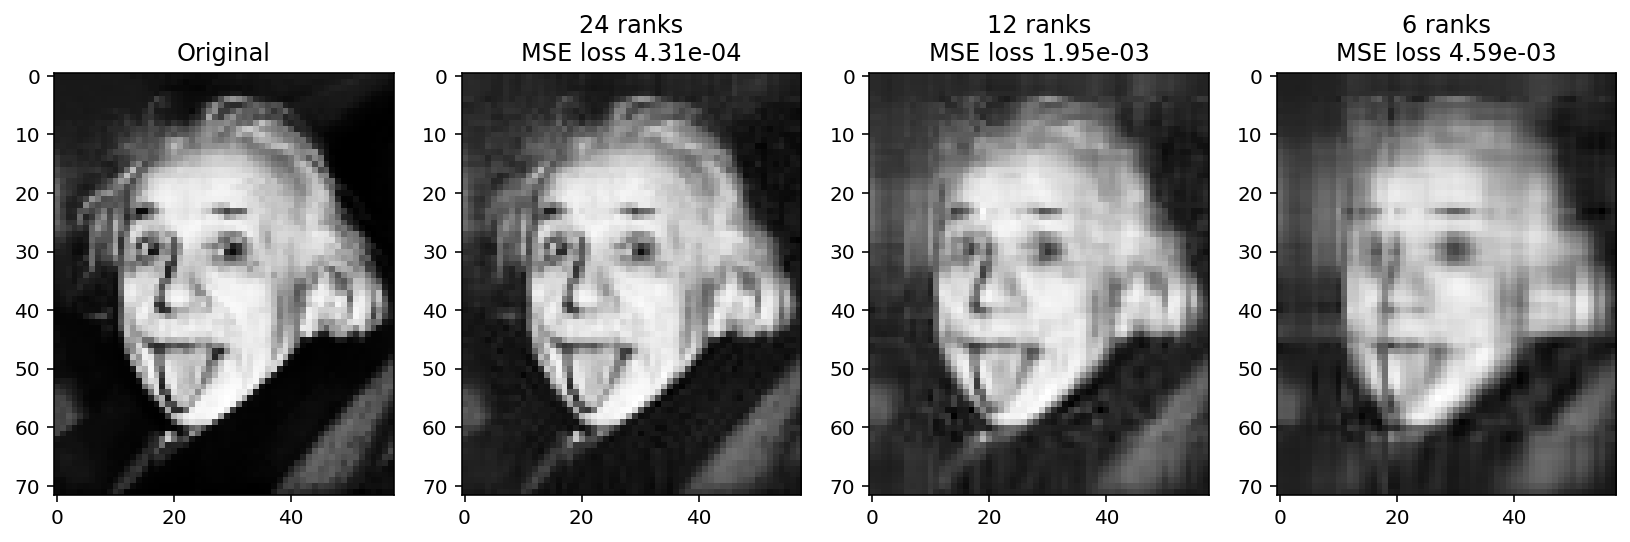

In [5]:
n, m = img.shape

fig, axs = plt.subplots(1, 4, figsize=(14, 4))
axs[0].imshow(img, cmap='Greys_r')
axs[0].set_title('Original')
fac_svd = {}

for r, ax in zip(ranks, axs[1:]):
    u = ff.tensor('u', n, r, initializer=ff.initializers.Normal)
    v = ff.tensor('v', m, r, initializer=ff.initializers.Normal)
    i, j, k = ff.indices('i, j, k')
    tsrex = u[i, j] * v[k, j]
    fac = ff.factorize(tsrex, img, lr=0.1, max_steps=1000)
    fac_svd[r] = fac
    img_compressed = fac()
    ax.imshow(img_compressed, cmap='Greys_r')
    ax.set_title('{} ranks\nMSE loss {:.2e}'.format(r, ff.loss.mse_loss(img_compressed, img)))

display(tsrex)
plt.show()

## Solving [RBF approximation](https://arxiv.org/abs/2106.02018) with gradient descent

100%|██████████| 10000/10000 [00:58<00:00, 170.67it/s]


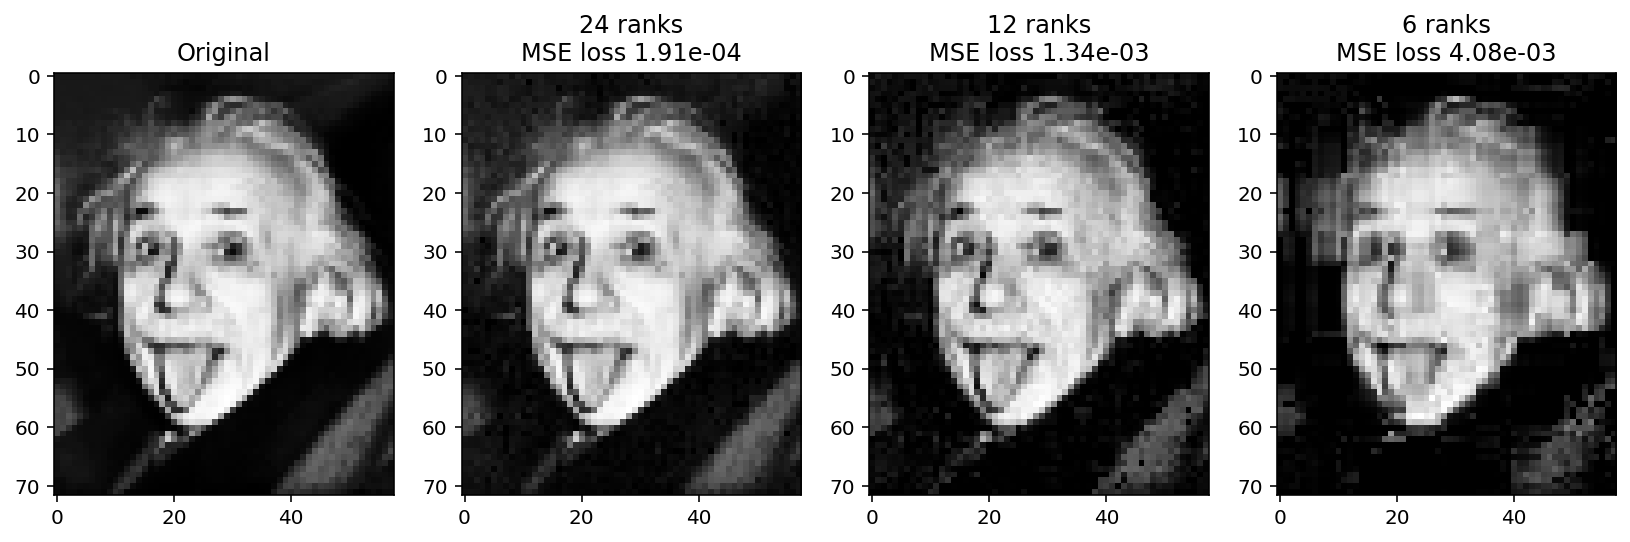

In [6]:
n, m = img.shape

fig, axs = plt.subplots(1, 4, figsize=(14, 4))
axs[0].imshow(img, cmap='Greys_r')
axs[0].set_title('Original')
fac_rbf = {}

for r, ax in zip(ranks, axs[1:]):
    u = ff.tensor('u', n, r, initializer=ff.initializers.Normal)
    v = ff.tensor('v', m, r, initializer=ff.initializers.Normal)
    a = ff.tensor('a', r, initializer=ff.initializers.VarianceScaling(scale=np.var(img), axis=0))
    b = ff.tensor('b')
    i, j, k = ff.indices('i, j, k')
    tsrex = ff.exp(-(u[i, ~k] - v[j, ~k])**2) * a[k] + b[[]]
    fac = ff.factorize(tsrex, img, nvec=16, lr=1e-1, max_steps=10000)
    fac_rbf[r] = fac
    img_compressed = fac()
    ax.imshow(img_compressed, cmap='Greys_r')
    ax.set_title('{} ranks\nMSE loss {:.2e}'.format(r, ff.loss.mse_loss(img_compressed, img)))

display(tsrex)
plt.show()

## Side-by-side comparison

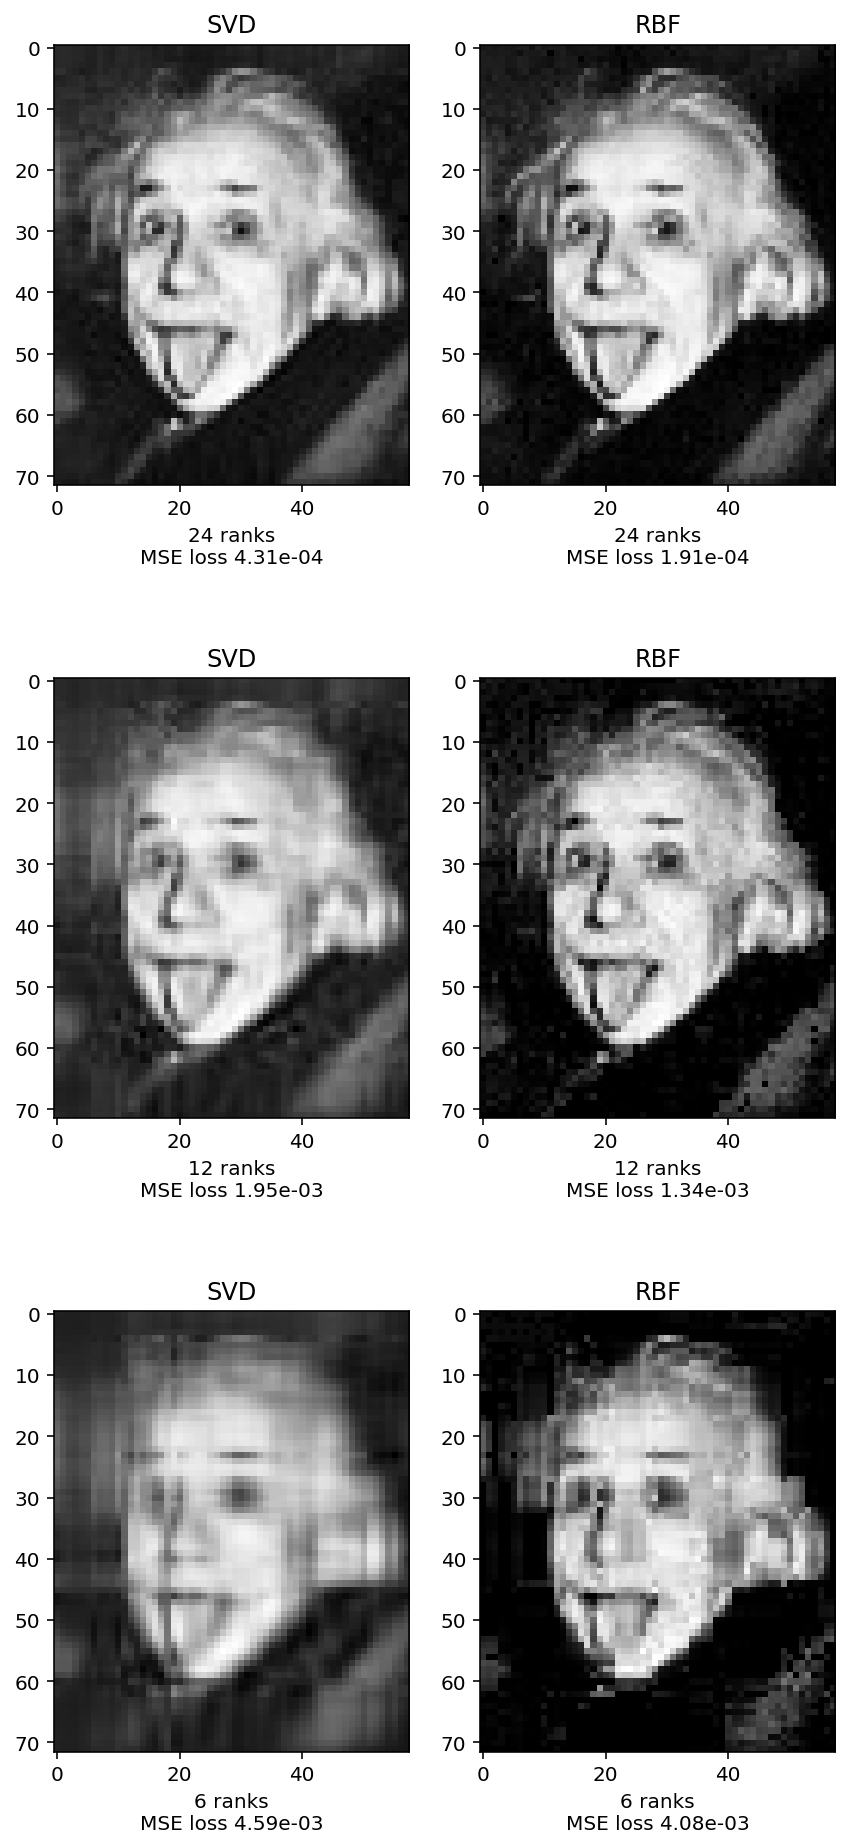

In [7]:
fig, axs = plt.subplots(len(ranks), 2, figsize=(7, 5.5 * len(ranks)))

for r, axrow in zip(ranks, axs):
    for fac, ax in zip((fac_svd[r], fac_rbf[r]), axrow):
        ax.imshow(fac(), cmap='Greys_r')
        ax.set_xlabel('{} ranks\nMSE loss {:.2e}'.format(r, ff.loss.mse_loss(fac(), img)))

    axrow[0].set_title('SVD')
    axrow[1].set_title('RBF')

plt.show()

---